In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import gc
import glob
import torch
import utils
from scipy.special import erf
from sklearn.calibration import calibration_curve
from sklearn.metrics import (auc, brier_score_loss, confusion_matrix,
                             mean_absolute_error, mean_squared_error,
                             precision_recall_curve, r2_score, roc_curve,
							 precision_score, recall_score, f1_score,
                             mutual_info_score)
from sklearn.feature_selection import mutual_info_regression, r_regression
from scipy.stats import entropy
import utils

In [2]:
model_type = 'swmag'
shap_dir = 'outputs/shap_values'
scaler_dir = 'outputs/scalers'
results_dir = 'outputs/rsd'
VERSION = 'swmag_v6-1'
shap_files = glob.glob(f'{shap_dir}/*{VERSION}*.pkl')
scaler_files = glob.glob(f'{scaler_dir}/*{VERSION}.pkl')
results_files = glob.glob(f'{scaler_dir}/*{VERSION}.feather')
with open('cluster_dict.pkl', 'rb') as f:
	cluster_dict = pickle.load(f)

list_of_oversampled_regions = ['GRL-1', 'GRL-2', 'SVLB', 'JPN-0']

In [3]:
scalers = {}
for cluster in cluster_dict.values():
	for key, region in cluster['regions'].items():
		scalers[key] = {}
		if key in list_of_oversampled_regions:
			if os.path.exists(f'{scaler_dir}/twins_{key}_twins_v_maxpooling_oversampling.pkl'):
				with open(f'{scaler_dir}/twins_{key}_twins_v_maxpooling_oversampling.pkl', 'rb') as f:
					scaler_values = pickle.load(f)
					scalers[key]['twins'] = scaler_values
			if os.path.exists(f'{scaler_dir}/swmag_{key}_swmag_v6-oversampling.pkl'):
				with open(f'{scaler_dir}/swmag_{key}_swmag_v6-oversampling.pkl', 'rb') as f:
					scaler_values = pickle.load(f)
					scalers[key]['swmag'] = scaler_values
					print(f'{key} scalers loaded')
		else:
			if os.path.exists(f'{scaler_dir}/twins_{key}_twins_v_maxpooling.pkl'):
				with open(f'{scaler_dir}/twins_{key}_twins_v_maxpooling.pkl', 'rb') as f:
					scaler_values = pickle.load(f)
					scalers[key]['twins'] = scaler_values
			if os.path.exists(f'{scaler_dir}/swmag_{key}_swmag_v6-1.pkl'):
				with open(f'{scaler_dir}/swmag_{key}_swmag_v6-1.pkl', 'rb') as f:
					scaler_values = pickle.load(f)
					scalers[key]['swmag'] = scaler_values
					print(f'{key} scalers loaded')

CAN-0 scalers loaded
CAN-1 scalers loaded
CAN-2 scalers loaded
GRL-0 scalers loaded
GRL-1 scalers loaded
GRL-2 scalers loaded
GRL-3 scalers loaded
FSC-0 scalers loaded
FSC-1 scalers loaded
FSC-2 scalers loaded
FSC-3 scalers loaded
FSC-4 scalers loaded
FSC-5 scalers loaded
FSC-6 scalers loaded
CEU-0 scalers loaded
CEU-1 scalers loaded
CEU-2 scalers loaded
CEU-3 scalers loaded
SVLB scalers loaded
JPN-0 scalers loaded
JPN-1 scalers loaded
ALSK scalers loaded
HUD-0 scalers loaded
HUD-1 scalers loaded


In [6]:
for cluster in cluster_dict.values():
	for key, region in cluster['regions'].items():
		if key in list_of_oversampled_regions:
			if os.path.exists(f'{shap_dir}/{model_type}_region_{key}_swmag_v6-oversampling.pkl'):
				with open(f'{shap_dir}/{model_type}_region_{key}_swmag_v6-oversampling.pkl', 'rb') as f:
					shap_values = pickle.load(f)
					cluster['regions'][key]['swmag_shap'] = shap_values
			# if os.path.exists(f'{shap_dir}/twins_region_{key}_twins_v_maxpooling_oversampling.pkl'):
			# 	with open(f'{shap_dir}/twins_region_{key}_twins_v_maxpooling_oversampling.pkl', 'rb') as f:
			# 		shap_values = pickle.load(f)
			# 		cluster['regions'][key]['twins_shap'] = shap_values
		else:
			if os.path.exists(f'{shap_dir}/{model_type}_region_{key}_swmag_v6-1.pkl'):
				with open(f'{shap_dir}/{model_type}_region_{key}_swmag_v6-1.pkl', 'rb') as f:
					shap_values = pickle.load(f)
					cluster['regions'][key]['swmag_shap'] = shap_values
			# if os.path.exists(f'{shap_dir}/twins_region_{key}_twins_v_maxpooling.pkl'):
			# 	with open(f'{shap_dir}/twins_region_{key}_twins_v_maxpooling.pkl', 'rb') as f:
			# 		shap_values = pickle.load(f)
			# 		cluster['regions'][key]['twins_shap'] = shap_values

In [16]:
# individual_cluster_to_examine = 'canadian_cluster'
feature_mean, feature_std, mean_shap, std_shap, X, mu, sigma, error = [], [], [], [], [], [], [], []
for cluster in cluster_dict.keys():
	for reg, region in cluster_dict[cluster]['regions'].items():
		if f'{model_type}_shap' in region.keys():

			region[f'{model_type}_shap']['mean_shap'] = np.concatenate([region[f'{model_type}_shap']['shap_values'][i][0][:,:,:,:] for i in range(len(region[f'{model_type}_shap']['shap_values']))], axis=0)
			region[f'{model_type}_shap']['std_shap'] = np.concatenate([region[f'{model_type}_shap']['shap_values'][i][1][:,:,:,:] for i in range(len(region[f'{model_type}_shap']['shap_values']))], axis=0)

			if reg in list_of_oversampled_regions:
				region[f'{model_type}_shap']['xtest'] = region['swmag_shap']['testing_data']
			else:
				region[f'{model_type}_shap']['xtest'] = region['swmag_shap']['xtest']


			for key in region[f'{model_type}_shap'].keys():
				if isinstance(region[f'{model_type}_shap'][key], torch.Tensor):
					region[f'{model_type}_shap'][key] = region[f'{model_type}_shap'][key].cpu().detach().numpy()
			region[f'{model_type}_shap']['mean_shap'] = region[f'{model_type}_shap']['mean_shap'].reshape(region[f'{model_type}_shap']['mean_shap'].shape[0], region[f'{model_type}_shap']['mean_shap'].shape[2], region[f'{model_type}_shap']['mean_shap'].shape[3])
			region[f'{model_type}_shap']['std_shap'] = region[f'{model_type}_shap']['std_shap'].reshape(region[f'{model_type}_shap']['std_shap'].shape[0], region[f'{model_type}_shap']['std_shap'].shape[2], region[f'{model_type}_shap']['std_shap'].shape[3])
			if region[f'{model_type}_shap']['xtest'].shape[1] < 3:
				region[f'{model_type}_shap']['xtest'] = region[f'{model_type}_shap']['xtest'].reshape(region[f'{model_type}_shap']['xtest'].shape[0], region[f'{model_type}_shap']['xtest'].shape[2], region[f'{model_type}_shap']['xtest'].shape[3])
			mean_added = np.sum(np.sum(np.abs(region[f'{model_type}_shap']['mean_shap']), axis=1),axis=1)
			region[f'{model_type}_shap']['mean_shap'] = region[f'{model_type}_shap']['mean_shap']/mean_added[:,None,None]

			std_added = np.sum(np.sum(np.abs(region[f'{model_type}_shap']['std_shap']), axis=1),axis=1)
			region[f'{model_type}_shap']['std_shap'] = region[f'{model_type}_shap']['std_shap']/std_added[:,None,None]

			region_scaler = scalers[reg][model_type]['swmag_scaler']

			# unbroadcasted_mu = results[reg]['swmag_results']['predicted_mean'].to_numpy()
			# unbroadcasted_sigma = results[reg]['swmag_results']['predicted_std'].to_numpy()
			# unbroadcasted_error = np.array(np.abs(results[reg]['swmag_results']['predicted_mean'] - results[reg]['swmag_results']['actual']))

			# concatenated_mu = np.concatenate([np.concatenate([unbroadcasted_mu[:,np.newaxis]]*30, axis=1)[:,:,np.newaxis]]*14, axis=2)
			# concatenated_sigma = np.concatenate([np.concatenate([unbroadcasted_sigma[:,np.newaxis]]*30, axis=1)[:,:,np.newaxis]]*14, axis=2)
			# concatenated_error = np.concatenate([np.concatenate([unbroadcasted_error[:,np.newaxis]]*30, axis=1)[:,:,np.newaxis]]*14, axis=2)

			# mu.append(np.concatenate(concatenated_mu, axis=0))
			# sigma.append(np.concatenate(concatenated_sigma, axis=0))
			# error.append(np.concatenate(concatenated_error, axis=0))

			feature_mean.append(np.sum(region[f'{model_type}_shap']['mean_shap'], axis=1))
			feature_std.append(np.sum(region[f'{model_type}_shap']['std_shap'], axis=1))
			mean_shap.append(np.concatenate(region[f'{model_type}_shap']['mean_shap'], axis=0))
			std_shap.append(np.concatenate(region[f'{model_type}_shap']['std_shap'], axis=0))

			X.append(region_scaler.inverse_transform(np.concatenate(region[f'{model_type}_shap']['xtest'], axis=0)))

mean_shap = np.concatenate(mean_shap, axis=0)
std_shap = np.concatenate(std_shap, axis=0)

# feature_mean = np.mean(np.abs(feature_mean), axis=0)
# feature_std = np.mean(np.abs(feature_std), axis=0)

# print(mean_shap.shape)
X = np.concatenate(X, axis=0)
# mu = np.concatenate(mu, axis=0)
# sigma = np.concatenate(sigma, axis=0)
# error = np.concatenate(error, axis=0)

swmag_mean_shap_df = pd.DataFrame(mean_shap, columns=shap_values['features'])
swmag_std_shap_df = pd.DataFrame(std_shap, columns=shap_values['features'])

transformed_X_df = pd.DataFrame(X, columns=shap_values['features'])
# mu_df = pd.DataFrame(mu, columns=shap_values['features'])
# sigma_df = pd.DataFrame(sigma, columns=shap_values['features'])
# error_df = pd.DataFrame(error, columns=shap_values['features'])

# print(swmag_mean_shap_df.shape)
# print(error_df.shape)

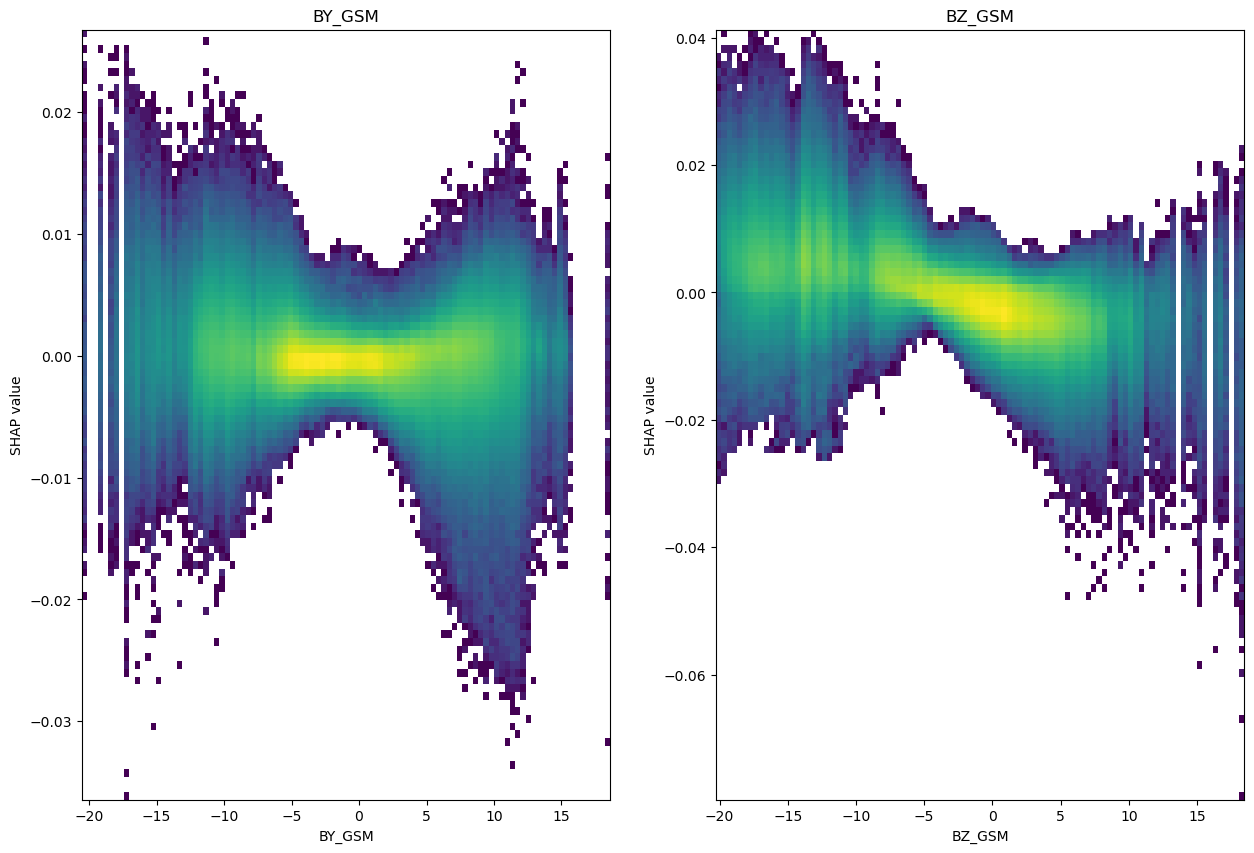

In [18]:
feature = ['BY_GSM', 'BZ_GSM']

fig, axes = plt.subplots(1, len(feature), figsize=(15, 10))
for i, ax in enumerate(axes):
	axes[i].hist2d(transformed_X_df[feature[i]], swmag_mean_shap_df[feature[i]], bins=100, cmap='viridis', norm=mpl.colors.LogNorm())
	ax.set_title(f'{feature[i]}')
	ax.set_xlabel(feature[i])
	ax.set_ylabel('SHAP value')
plt.savefig(f'plots/{feature[0]}_and_{feature[1]}')

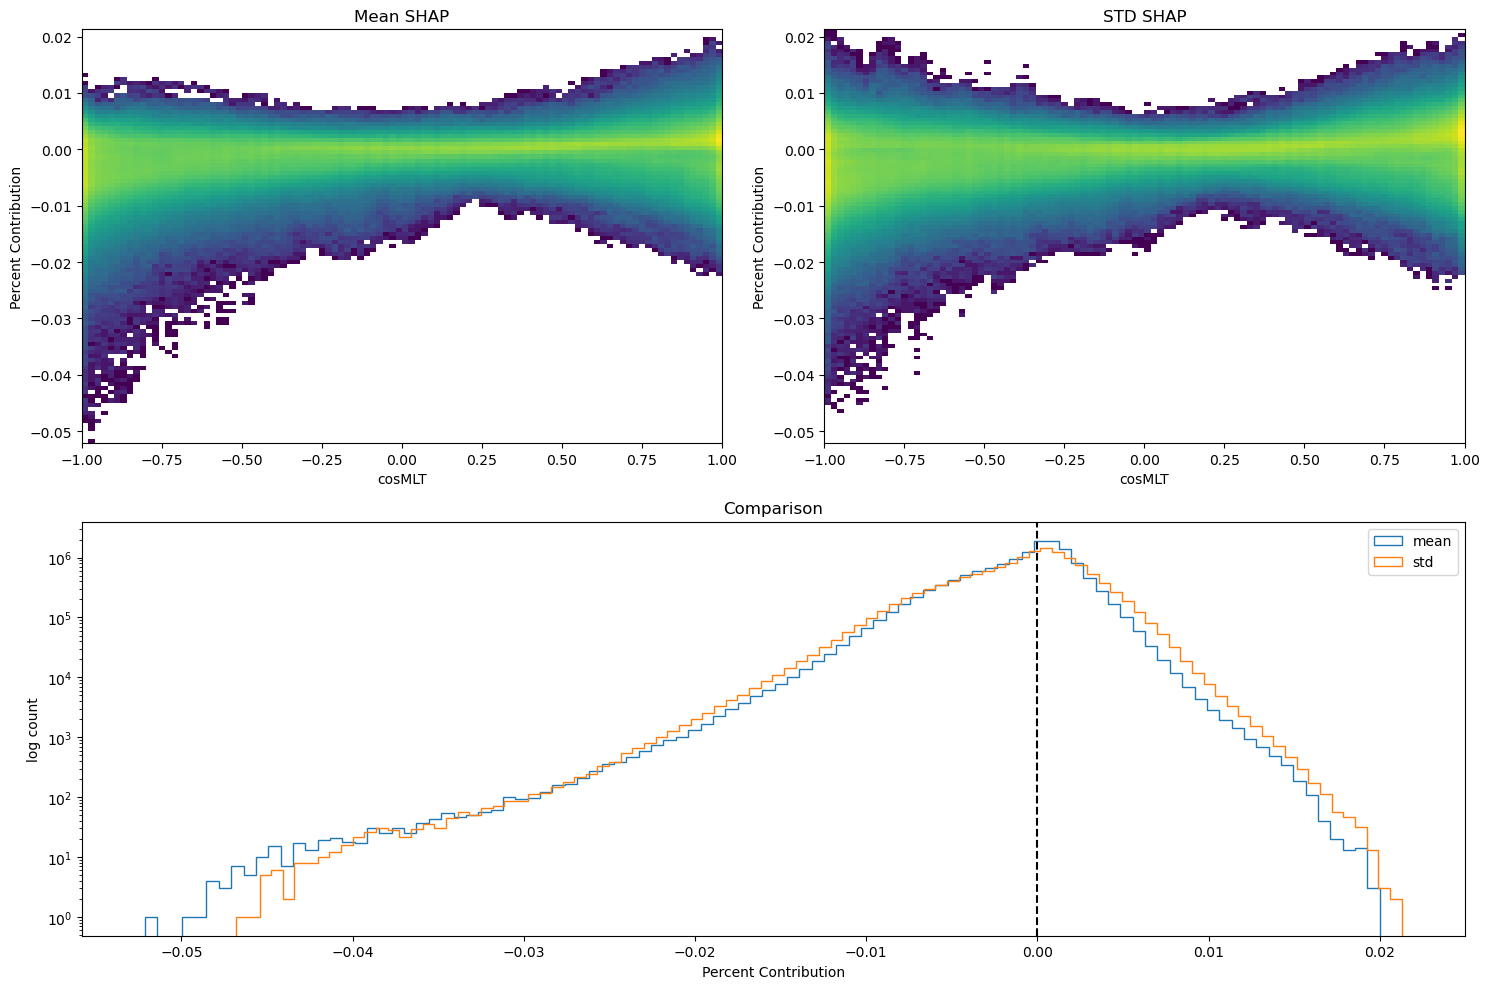

In [19]:
feature = 'cosMLT'

vmin = np.min([np.min(swmag_std_shap_df[feature]), np.min(swmag_mean_shap_df[feature])])
vmax = np.max([np.max(swmag_std_shap_df[feature]),np.max(swmag_mean_shap_df[feature])])

fig, axes = plt.subplot_mosaic("AB;DD", figsize=(15,10))
axes['A'].hist2d(transformed_X_df[feature], swmag_mean_shap_df[feature], bins=100, cmap='viridis', norm=mpl.colors.LogNorm())
axes['B'].hist2d(transformed_X_df[feature], swmag_std_shap_df[feature], bins=100, cmap='viridis', norm=mpl.colors.LogNorm())
plt.title(f'{feature}')
axes['A'].set_ylabel('Percent Contribution')
axes['A'].set_xlabel(feature)
axes['A'].set_xlim(np.min(transformed_X_df[feature]), np.max(transformed_X_df[feature]))
axes['A'].set_ylim(vmin, vmax)
axes['A'].set_title('Mean SHAP')

axes['B'].set_xlim(np.min(transformed_X_df[feature]), np.max(transformed_X_df[feature]))
axes['B'].set_ylim(vmin, vmax)
axes['B'].set_xlabel(feature)
axes['B'].set_ylabel('Percent Contribution')
axes['B'].set_title('STD SHAP')

axes['D'].set_title('Comparison')
axes['D'].hist(swmag_mean_shap_df[feature], bins=100, log=True, histtype='step', label='mean')
axes['D'].hist(swmag_std_shap_df[feature], bins=100, log=True, histtype='step', label='std')
axes['D'].set_ylabel('log count')
axes['D'].set_xlabel('Percent Contribution')
axes['D'].axvline(0, linestyle='--', color='k')
axes['D'].legend()

plt.tight_layout()
plt.savefig(f'plots/{feature}_swmag_shap_value_distributions.png')

# getting area under the curve of the 1D histograms
from sklearn.metrics import auc
mean_hist, mean_bins = np.histogram(swmag_mean_shap_df[feature], bins=100)
std_hist, std_bins = np.histogram(swmag_std_shap_df[feature], bins=100)
mean_area = auc(mean_bins[:-1], mean_hist)
std_area = auc(std_bins[:-1], std_hist)


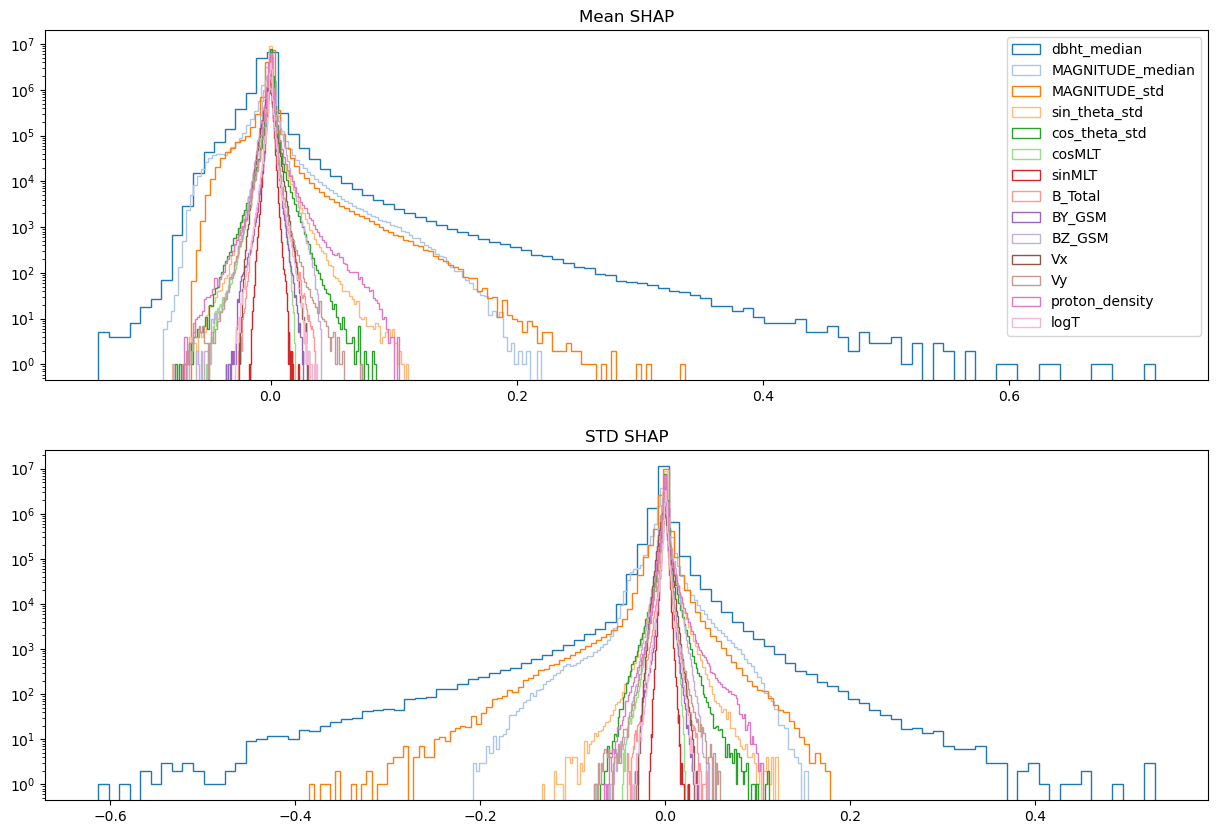

In [20]:
colors = sns.color_palette('tab20')

fig, axes = plt.subplots(2,1, figsize=(15,10))

for i, col in enumerate(shap_values['features']):
	axes[0].hist(swmag_mean_shap_df[col], bins=100, log=True, histtype='step', label=col, color=colors[i])
	axes[1].hist(swmag_std_shap_df[col], bins=100, log=True, histtype='step', label=col, color=colors[i])

axes[0].set_title('Mean SHAP')
axes[1].set_title('STD SHAP')

axes[0].legend()
plt.show()

In [33]:
# individual_cluster_to_examine = 'canadian_cluster'
mean_shap, std_shap, X, mu, sigma, error = [], [], [], [], [], []
dataframes_to_make = ['mean_shap_df', 'std_shap_df', 'transformed_X_df']
time_dict = {f'{feature}':{} for feature in shap_values['features']}

for feat in time_dict.keys():
	for df in dataframes_to_make:
		time_dict[feat][df] = pd.DataFrame()
for cluster in cluster_dict.keys():
	for reg, region in cluster_dict[cluster]['regions'].items():
		if f'{model_type}_shap' in region.keys():

			region[f'{model_type}_shap']['mean_shap'] = np.concatenate([region[f'{model_type}_shap']['shap_values'][i][0][:,:,:,:] for i in range(len(region[f'{model_type}_shap']['shap_values']))], axis=0)
			region[f'{model_type}_shap']['std_shap'] = np.concatenate([region[f'{model_type}_shap']['shap_values'][i][1][:,:,:,:] for i in range(len(region[f'{model_type}_shap']['shap_values']))], axis=0)

			for key in region[f'{model_type}_shap'].keys():
				if isinstance(region[f'{model_type}_shap'][key], torch.Tensor):
					region[f'{model_type}_shap'][key] = region[f'{model_type}_shap'][key].cpu().detach().numpy()

			try:
				region[f'{model_type}_shap']['mean_shap'] = region[f'{model_type}_shap']['mean_shap'].reshape(region[f'{model_type}_shap']['mean_shap'].shape[0], region[f'{model_type}_shap']['mean_shap'].shape[2], region[f'{model_type}_shap']['mean_shap'].shape[3])
				region[f'{model_type}_shap']['std_shap'] = region[f'{model_type}_shap']['std_shap'].reshape(region[f'{model_type}_shap']['std_shap'].shape[0], region[f'{model_type}_shap']['std_shap'].shape[2], region[f'{model_type}_shap']['std_shap'].shape[3])
				region[f'{model_type}_shap']['xtest'] = region[f'{model_type}_shap']['xtest'].reshape(region[f'{model_type}_shap']['xtest'].shape[0], region[f'{model_type}_shap']['xtest'].shape[2], region[f'{model_type}_shap']['xtest'].shape[3])

				mean_added = np.sum(np.sum(np.abs(region[f'{model_type}_shap']['mean_shap']), axis=1),axis=1)
				region[f'{model_type}_shap']['mean_shap'] = region[f'{model_type}_shap']['mean_shap']/mean_added[:,None,None]

				std_added = np.sum(np.sum(np.abs(region[f'{model_type}_shap']['std_shap']), axis=1),axis=1)
				region[f'{model_type}_shap']['std_shap'] = region[f'{model_type}_shap']['std_shap']/std_added[:,None,None]

			except:
				# print('We already did this, skipping....')
				pass

			region_scaler = scalers[reg][model_type]['swmag_scaler']


			for v, var in enumerate(time_dict.keys()):
				time_dict[var]['mean_shap_df'] = pd.concat([time_dict[var]['mean_shap_df'], pd.DataFrame(region[f'{model_type}_shap']['mean_shap'][:,:,v])], axis=0)
				time_dict[var]['std_shap_df'] = pd.concat([time_dict[var]['std_shap_df'], pd.DataFrame(region[f'{model_type}_shap']['std_shap'][:,:,v])], axis=0)
				time_dict[var]['transformed_X_df'] = pd.concat([time_dict[var]['transformed_X_df'], \
																pd.DataFrame(np.array([region_scaler.inverse_transform(region[f'{model_type}_shap']['xtest'][i,:,:]) \
																for i in range(region[f'{model_type}_shap']['xtest'].shape[0])])[:,:,v])], axis=0)

			# mu.append(np.concatenate(concatenated_mu, axis=0))
			# sigma.append(np.concatenate(concatenated_sigma, axis=0))
			# error.append(np.concatenate(concatenated_error, axis=0))

			mean_shap.append(np.concatenate(region[f'{model_type}_shap']['mean_shap'], axis=0))
			std_shap.append(np.concatenate(region[f'{model_type}_shap']['std_shap'], axis=0))
			X.append(region_scaler.inverse_transform(np.concatenate(region[f'{model_type}_shap']['xtest'], axis=0)))

time_columns = [f't-{30-i}' for i in range(0,30)]
for var in time_dict.keys():
	for df in time_dict[var]:
		print(f'Creating {var} {df} dataframe')
		print(time_dict[var][df].shape)
		time_dict[var][df].columns = time_columns

mean_shap = np.concatenate(mean_shap, axis=0)
std_shap = np.concatenate(std_shap, axis=0)
X = np.concatenate(X, axis=0)
# mu = np.concatenate(mu, axis=0)
# sigma = np.concatenate(sigma, axis=0)
# error = np.concatenate(error, axis=0)

mean_shap_df = pd.DataFrame(mean_shap, columns=shap_values['features'])
std_shap_df = pd.DataFrame(std_shap, columns=shap_values['features'])
transformed_X_df = pd.DataFrame(X, columns=shap_values['features'])
# mu_df = pd.DataFrame(mu, columns=shap_values['features'])
# sigma_df = pd.DataFrame(sigma, columns=shap_values['features'])
# error_df = pd.DataFrame(error, columns=shap_values['features'])



Creating dbht_median mean_shap_df dataframe
(461031, 30)
Creating dbht_median std_shap_df dataframe
(461031, 30)
Creating dbht_median transformed_X_df dataframe
(461031, 30)
Creating MAGNITUDE_median mean_shap_df dataframe
(461031, 30)
Creating MAGNITUDE_median std_shap_df dataframe
(461031, 30)
Creating MAGNITUDE_median transformed_X_df dataframe
(461031, 30)
Creating MAGNITUDE_std mean_shap_df dataframe
(461031, 30)
Creating MAGNITUDE_std std_shap_df dataframe
(461031, 30)
Creating MAGNITUDE_std transformed_X_df dataframe
(461031, 30)
Creating sin_theta_std mean_shap_df dataframe
(461031, 30)
Creating sin_theta_std std_shap_df dataframe
(461031, 30)
Creating sin_theta_std transformed_X_df dataframe
(461031, 30)
Creating cos_theta_std mean_shap_df dataframe
(461031, 30)
Creating cos_theta_std std_shap_df dataframe
(461031, 30)
Creating cos_theta_std transformed_X_df dataframe
(461031, 30)
Creating cosMLT mean_shap_df dataframe
(461031, 30)
Creating cosMLT std_shap_df dataframe
(461031

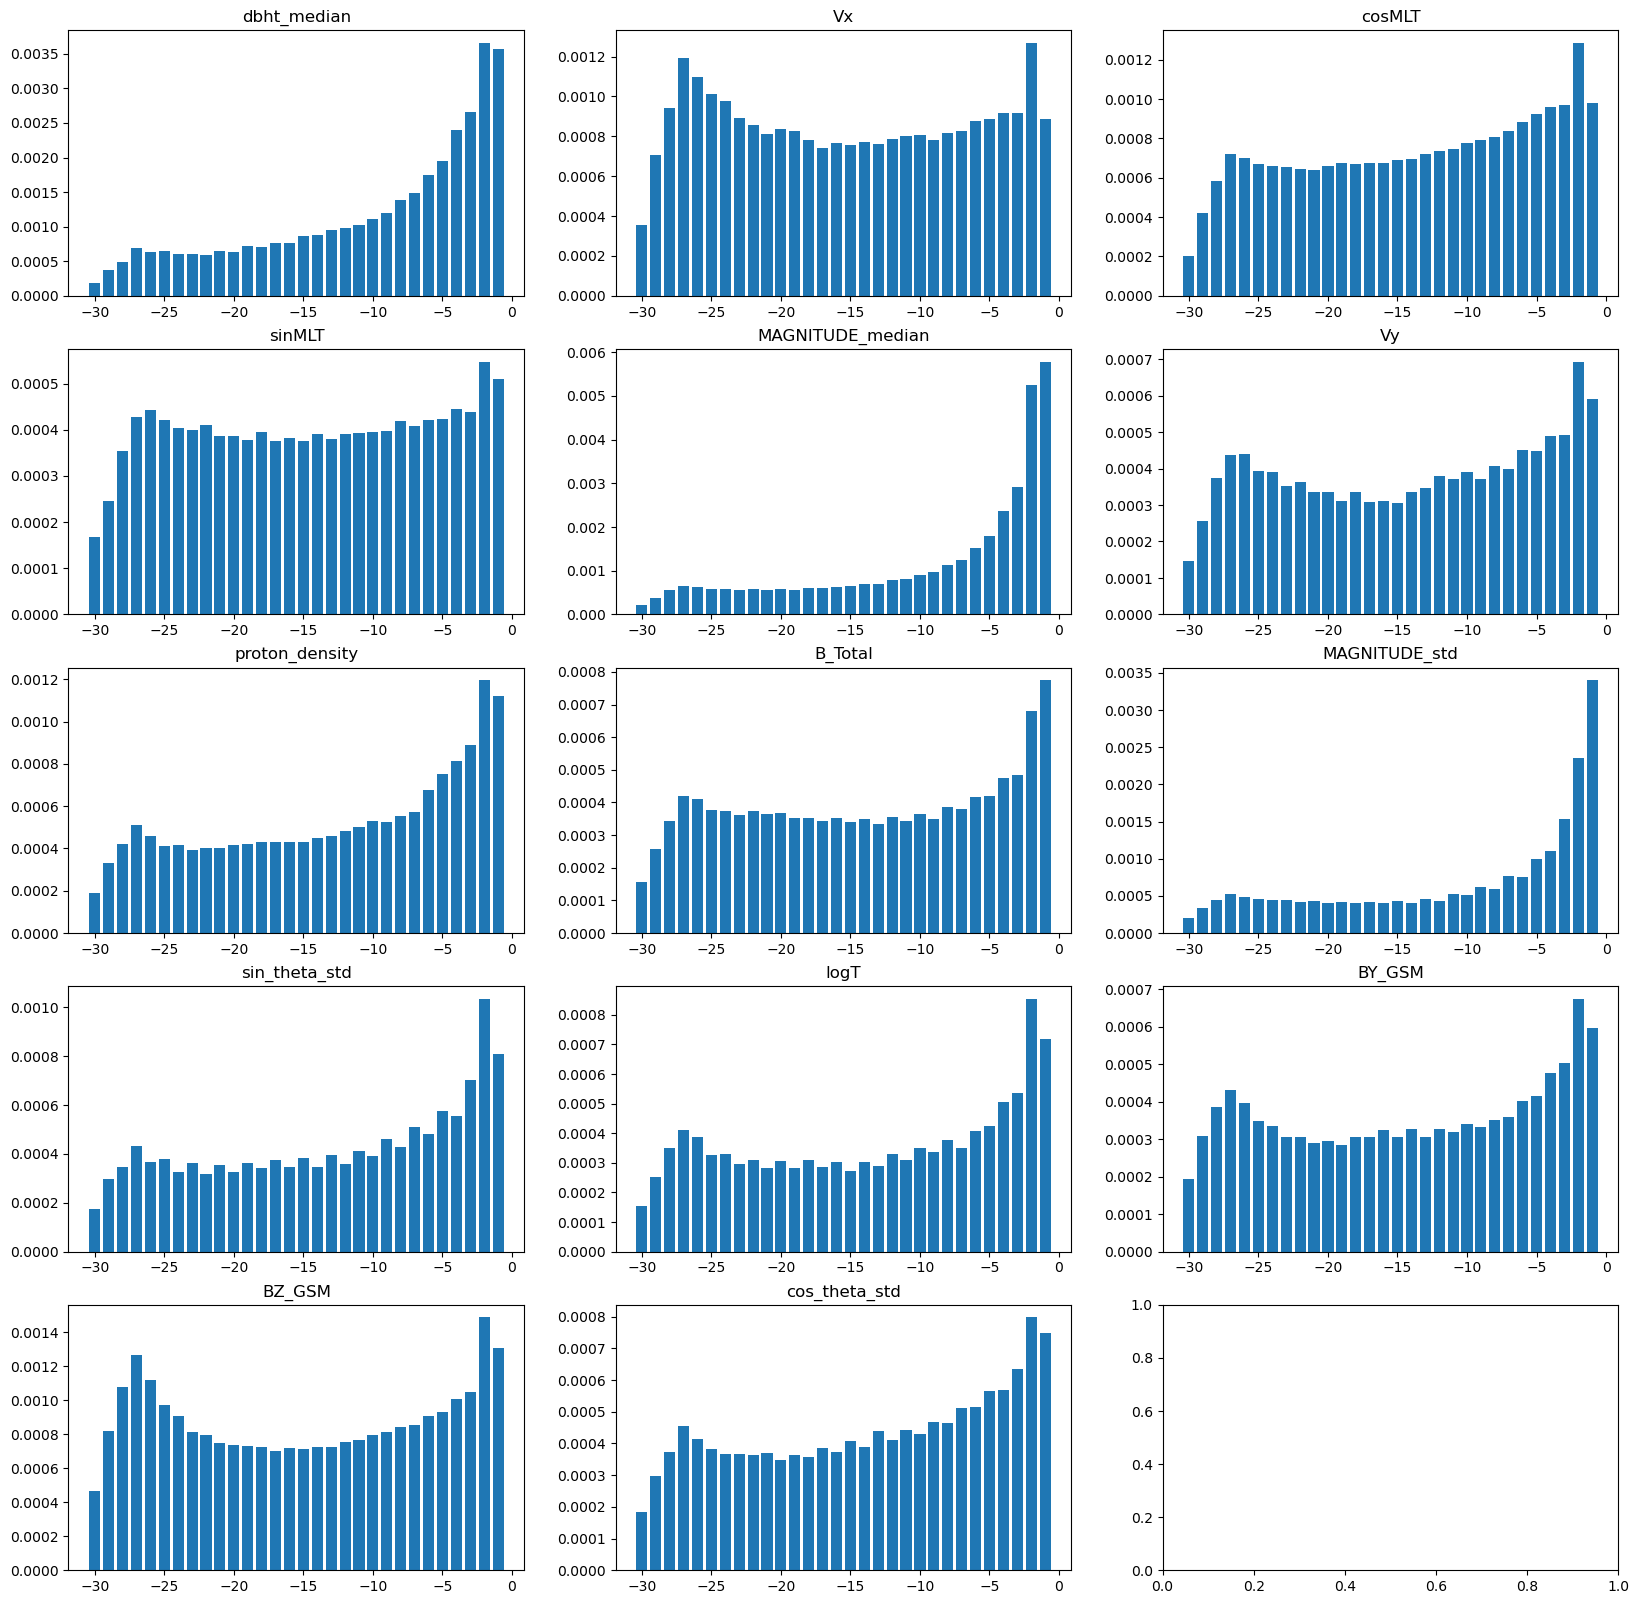

In [26]:
# var = 'BY_GSM'
df = 'std_shap_df'

fig, axes = plt.subplots(5, 3, figsize=(20,20))
for i, var in enumerate(time_dict.keys()):
	k = i%3
	j = i%5
	axes[j,k].bar([i-30 for i in range(0,30)], time_dict[var][df].abs().mean(axis=0))
	axes[j,k].set_title(var)
plt.savefig(f'plots/time_history_{df}.png')

In [34]:
results = {}
for cluster in cluster_dict.values():
	for key, region in cluster['regions'].items():
		results[key] = {}
		if key in list_of_oversampled_regions:
			results[key]['swmag_results'] = pd.read_feather(f'{results_dir}/non_twins_modeling_region_{key}_version_swmag_v6-oversampling.feather')
			results[key]['twins_results'] = pd.read_feather(f'{results_dir}/twins_modeling_region_{key}_version_twins_v_maxpooling_oversampling.feather')
		else:
			results[key]['swmag_results'] = pd.read_feather(f'{results_dir}/non_twins_modeling_region_{key}_version_swmag_v6-1.feather')
			results[key]['twins_results'] = pd.read_feather(f'{results_dir}/twins_modeling_region_{key}_version_twins_v_maxpooling.feather')
		results[key]['mean_lat'] = utils.getting_mean_lat(region['stations'])

for cluster in cluster_dict.values():
	for region in cluster['regions'].values():
		region['mean_lat'] = utils.getting_mean_lat(region['stations'])

Loading station NEW....
Loading station T19....
Loading station C10....
Loading station LET....
Loading station T03....
Loading station T43....
Loading station LET....
Loading station T03....
Loading station T43....
Loading station RED....
Loading station C06....
Loading station T43....
Loading station RED....
Loading station C06....
Loading station MEA....
Loading station T36....
Loading station GHB....
Loading station SKT....
Loading station STF....
Loading station ATU....
Loading station SKT....
Loading station STF....
Loading station ATU....
Loading station GDH....
Loading station STF....
Loading station ATU....
Loading station GDH....
Loading station UMQ....
Loading station GHB....
Loading station FHB....
Loading station NAQ....
Loading station RVK....
Loading station LYC....
Loading station DON....
Loading station JCK....
Loading station HAN....
Loading station MEK....
Loading station OUJ....
Loading station NUR....
Loading station MAS....
Loading station NOR....
Loading station 

In [35]:
plotting_df = pd.DataFrame()
mlt_arr, actual_arr, mlat_arr = [], [], []
for cluster in cluster_dict.keys():
	for reg, region in cluster_dict[cluster]['regions'].items():

		df = utils.loading_supermag(region['mlt_station'])
		dates = region['swmag_shap']['Date_UTC']

		cluster_dict[cluster]['regions'][reg]['test_mlt'] = df[df.index.isin(dates['Date_UTC'])]['MLT']
		if 'dates' in results[reg]['swmag_results'].keys():
			results[reg]['swmag_results'].set_index('dates', inplace=True)
		results[reg]['swmag_results']['MLT'] = cluster_dict[cluster]['regions'][reg]['test_mlt']
		results[reg]['swmag_results']['error'] = np.abs(results[reg]['swmag_results']['predicted_mean'] - results[reg]['swmag_results']['actual'])
		results[reg]['swmag_results']['mlat'] = cluster_dict[cluster]['regions'][reg]['mean_lat']
		plotting_df = pd.concat([plotting_df, results[reg]['swmag_results']], axis=0)

		unbroadcasted_mlt = results[reg]['swmag_results']['MLT'].to_numpy()
		unbroadcasted_actual = results[reg]['swmag_results']['actual'].to_numpy()
		unbroadcasted_mlat = results[reg]['swmag_results']['mlat'].to_numpy()

		concatenated_mlt = np.concatenate([np.concatenate([unbroadcasted_mlt[:,np.newaxis]]*30, axis=1)[:,:,np.newaxis]]*14, axis=2)
		concatenated_actual = np.concatenate([np.concatenate([unbroadcasted_actual[:,np.newaxis]]*30, axis=1)[:,:,np.newaxis]]*14, axis=2)

		# mlt_arr.append(np.concatenate(concatenated_mlt, axis=0))
		# actual_arr.append(np.concatenate(concatenated_actual, axis=0))

		mlt_arr.append(np.repeat(results[reg]['swmag_results']['MLT'].to_numpy(), 30))
		actual_arr.append(np.repeat(results[reg]['swmag_results']['actual'].to_numpy(), 30))
		mlat_arr.append(np.repeat(results[reg]['swmag_results']['mlat'].to_numpy(), 30))

mlt_arr = np.concatenate(mlt_arr, axis=0)
actual_arr = np.concatenate(actual_arr, axis=0)
mlat_arr = np.concatenate(mlat_arr, axis=0)
time_history = np.concatenate((np.array([30-i for i in range(0,30)]),)*(len(mlt_arr)//30), axis=0)

# mlt_df = pd.DataFrame(mlt_arr, columns=shap_values['features'])
# actual_df = pd.DataFrame(actual_arr, columns=shap_values['features'])

plotting_mlt_mlat_shap_mean = mean_shap_df.copy()
plotting_mlt_mlat_shap_mean['MLT'] = mlt_arr
plotting_mlt_mlat_shap_mean['mlat'] = mlat_arr
plotting_mlt_mlat_shap_mean['actual'] = actual_arr
plotting_mlt_mlat_shap_mean['time_history'] = time_history


Loading station NEW....
Loading station LET....
Loading station MEA....
Loading station STF....
Loading station GDH....
Loading station GDH....
Loading station NAQ....
Loading station LYC....
Loading station NUR....
Loading station ABK....
Loading station ABK....
Loading station ABK....
Loading station ABK....
Loading station ABK....
Loading station BEL....
Loading station BEL....
Loading station HRB....
Loading station WNG....
Loading station HRN....
Loading station KNY....
Loading station MMB....
Loading station CMO....
Loading station PIN....
Loading station BLC....


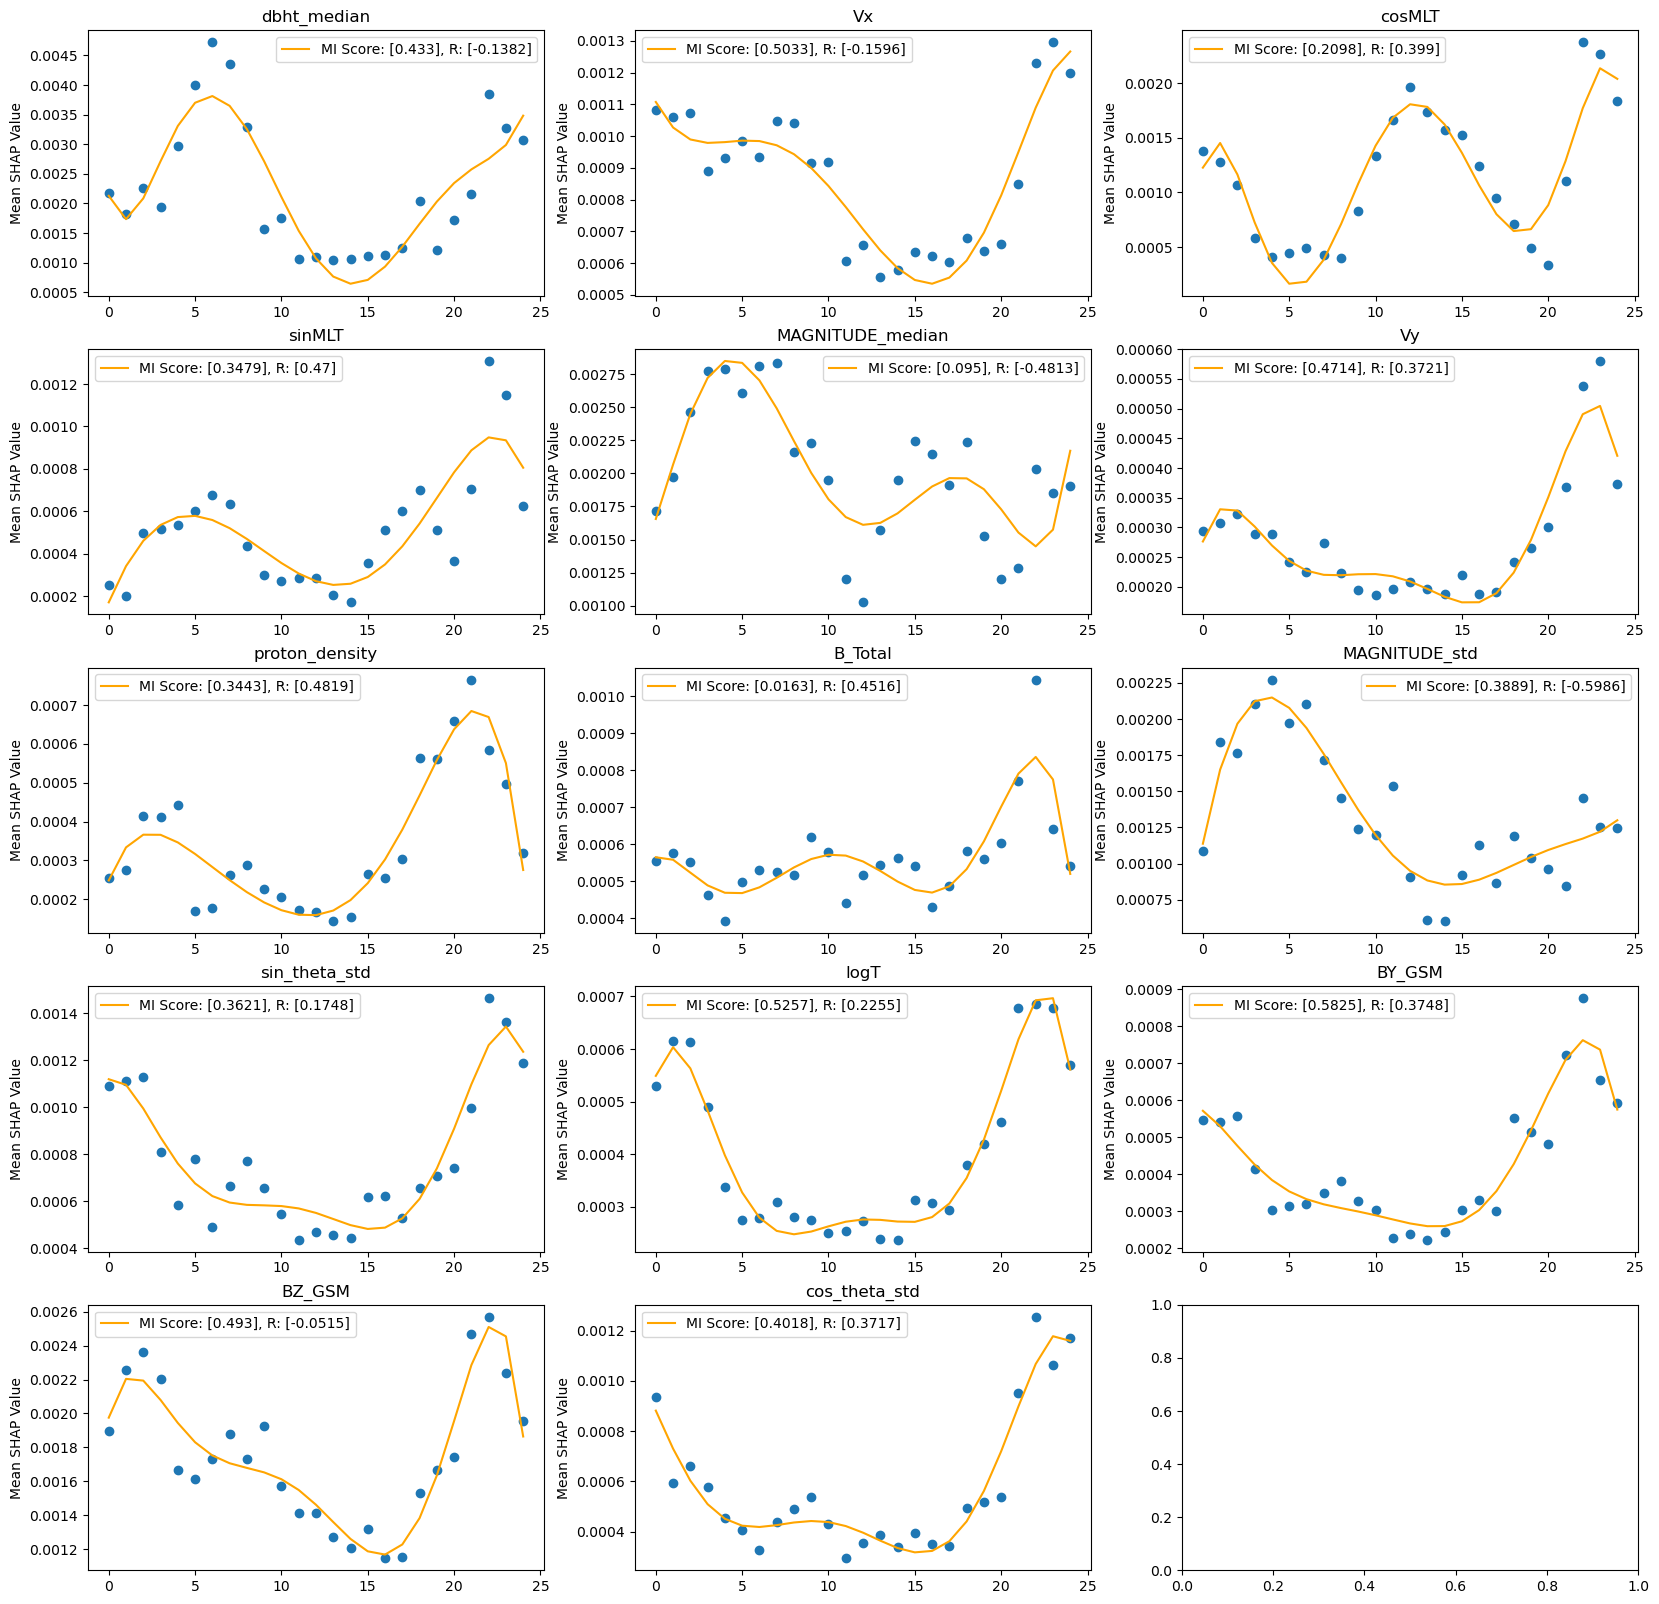

: 

In [41]:
specific_mlat = 67
specific_mlt = None
absolute = True
aggregation_method = 'mean'
time_history = False
cut_mlt = False
if not cut_mlt:
	round_mlt = True
else:
	round_mlt = False
mlt_cuts = 1000
mlt_bins = np.linspace(0,24,mlt_cuts+1).tolist()
specific_plotting_df = plotting_mlt_mlat_shap_mean.copy()
specific_plotting_df['mlat'] = specific_plotting_df['mlat'].astype(int)

title = f'{aggregation_method}_shap_'

if round_mlt:
	specific_plotting_df['MLT'] = specific_plotting_df['MLT'].round(0)
elif cut_mlt:
	specific_plotting_df['MLT_bins'] = pd.cut(specific_plotting_df['MLT'], mlt_bins, labels=mlt_bins[:-1], include_lowest=True)
	# specific_plotting_df = specific_plotting_df.groupby('MLT_bins').agg(aggregation_method)
else:
	raise ValueError('Must specify either round_mlt or cut_mlt')

if specific_mlat is not None:
	specific_plotting_df = specific_plotting_df[specific_plotting_df['mlat']==specific_mlat]
	title += f'{specific_mlat}_'

if specific_mlt is not None:
	specific_plotting_df = specific_plotting_df[specific_plotting_df['MLT']==specific_mlt]
	title += f'{specific_mlt}_'

if time_history:
	if specific_mlat is None and specific_mlt is None:
		raise ValueError('Cannot plot time history without specifying MLAT or MLT')
	if 'MLT_bins' in specific_plotting_df.columns:
		raise ValueError('Cannot plot time history with MLT bins. Change to int rounded MLT')
	specific_plotting_df = specific_plotting_df.groupby('time_history').agg(aggregation_method)
	title += 'time_history_'

if not time_history:
	if (specific_mlat is not None and specific_mlt is not None):
		raise ValueError('Cannot plot with specifying both MLAT and MLT')

	if absolute:
		specific_plotting_df = specific_plotting_df.apply(lambda x: x.abs() if (x.dtype=='float') or (x.dtype=='int') else x)
		if 'MLT_bins' in specific_plotting_df.columns:
			specific_plotting_df = specific_plotting_df.groupby('MLT_bins').agg(aggregation_method)
		else:
			specific_plotting_df = specific_plotting_df.groupby('MLT').agg(aggregation_method)
	else:
		if 'MLT_bins' in specific_plotting_df.columns:
			specific_plotting_df = specific_plotting_df.groupby('MLT_bins').agg(aggregation_method)
		else:
			specific_plotting_df = specific_plotting_df.groupby('MLT').agg(aggregation_method)
	title += 'absolute_shap' if absolute else 'relative_shap'

fig, axes = plt.subplots(5,3,figsize=(20,20))
for i, var in enumerate(specific_plotting_df.columns):
	if var == 'actual' or var == 'MLT' or var == 'mlat' or var == 'error' or var == 'time_history':
		continue
	j = i % 5
	k = i % 3
	mlt = np.array(specific_plotting_df.index)
	shap = specific_plotting_df[var].to_numpy()
	z = np.polyfit(mlt, shap, 6)
	p = np.poly1d(z)
	MI_x = mlt.reshape(-1,1)
	MI_y = shap
	axes[j,k].plot(mlt, p(mlt), color='orange', label=f'MI Score: {mutual_info_regression(MI_x, MI_y).round(4)}, R: {r_regression(MI_x, MI_y).round(4)}')
	axes[j,k].scatter(mlt, shap)
	axes[j,k].set_ylabel('Mean SHAP Value')
	axes[j,k].set_title(f'{var}')
	axes[j,k].legend()
plt.savefig(f'plots/mean_{title}.png')